# Ice Optics Parameterization Comparison (v1a)

# Test 1 - Altitude (Cloud Temperature)

For ranges used in Test 1 - Altitude/Temperature:

* Ice Mass Mixing ratio qi (kg/kg) range: (0.04 to 0.11) * 0.001

* Ice Water Content IWC (g/m3) (We use an average density of 0.3 kg m-3 between 10 km and 15 km):
iwc = q_i * 1000 * 0.3

* Ice Water Path IWP (g/m2):
iwp = np.arange(0.1, 300.1, 0.1)

* Fized Effective Radius r_e (um) (not needed for this case)

* Temperature T (K) range: 190 to 260.5 

In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import math
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator

%matplotlib notebook

# Interscheme Comparison

### Reading Tropical Climatology

In [2]:
in_dir    = ('/groups/sylvia/ecrad_tests/ecrad_test_1/')
file      = 'input_1D_matrix_height_v6.nc'
height_in = xr.open_dataset(in_dir+file)

In [3]:
tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',
                               sep='\s+ ')

/tmp/ipykernel_3747/1624852093.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tropical_profile = pd.read_csv('/home/u5/edgardo/p01_crh_sensitivity/tropical_profile_ellingson_250m.txt',


In [4]:
temp_int       = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['temperature (K)'].iloc[::-1])
temperature_hl = temp_int(height_in.pressure_hl.values)

height_int     = interpolate.interp1d(tropical_profile['pressure (hPa)'].iloc[::-1]*100,
                                      tropical_profile['height (km)'].iloc[::-1])
height_hl      = height_int(height_in.pressure_hl.values)

In [5]:
temp            = pd.Series(temperature_hl[0])
tropopause_i    = temp.argmin()
upper_limit_i   = (temp.iloc[tropopause_i:] - 201).abs().argmin()
lower_limit_i   = (temp.iloc[tropopause_i:] - 236).abs().argmin()
temp_range      = temp.iloc[tropopause_i+upper_limit_i:tropopause_i+lower_limit_i+1]
melting_layer_i = (temp - 273.15).abs().argmin()
melting_layer   = temp.iloc[melting_layer_i]
tropopause      = temp.min()

height_hl_pd    = pd.Series(height_hl[0])

### Reading Optical Schemes LUT

In [6]:
in_dir    = ('/groups/sylvia/ecrad_tests/LUT_SchComp/')

fu_sw = xr.open_dataset(in_dir+'FuSW_test1_LUT_v1a.nc')
fu_lw = xr.open_dataset(in_dir+'FuLW_test1_LUT_v1a.nc')
baran14_sw = xr.open_dataset(in_dir+'Baran14SW_test1_LUT_v1a.nc')
baran14_lw = xr.open_dataset(in_dir+'Baran14LW_test1_LUT_v1a.nc')
yi_sw = xr.open_dataset(in_dir+'YiSW_test1_LUT_v1a.nc')
yi_lw = xr.open_dataset(in_dir+'YiLW_test1_LUT_v1a.nc')
baran16_sw = xr.open_dataset(in_dir+'Baran16SW_test1_LUT_v1a.nc')
baran16_lw = xr.open_dataset(in_dir+'Baran16LW_test1_LUT_v1a.nc')

## Mass Absorption Coefficient $K_{abs}$ $(m^2/g)$:

Position of 30 um (Fixed Size):

In [7]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [8]:
fu_sw_K_abs = fu_sw.K_abs.values
fu_lw_K_abs = fu_lw.K_abs.values
baran14_sw_K_abs = baran14_sw.K_abs.values
baran14_lw_K_abs = baran14_lw.K_abs.values
yi_sw_K_abs = yi_sw.K_abs.values
yi_lw_K_abs = yi_lw.K_abs.values
baran16_sw_K_abs = baran16_sw.K_abs.values
baran16_lw_K_abs = baran16_lw.K_abs.values

Fu SW has some negative values for K_abs. Maybe because of high ssa. Check the parameterization.

In [9]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## K_abs Calculation Matrices:
K_abs_sw_t1 = np.zeros((4, tempi, profi))
K_abs_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
K_abs_sw_t1_plot = np.zeros((4, profi, tempi))
K_abs_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                K_abs_sw_t1[opt, i, q_ix] = 0
                K_abs_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                K_abs_sw_t1[0, i, q_ix] = fu_sw_K_abs[9, pos30, min_i] # Only One Band Selected 0.5 um
                K_abs_lw_t1[0, i, q_ix] = fu_lw_K_abs[6, pos30, min_i] # Only One Band Selected 9.7 um
                K_abs_sw_t1[1, i, q_ix] = baran14_sw_K_abs[9, min_i] # Only One Band Selected 0.5 um 
                K_abs_lw_t1[1, i, q_ix] = baran14_lw_K_abs[6, min_i] # Only One Band Selected 9.7 um
                K_abs_sw_t1[2, i, q_ix] = yi_sw_K_abs[9, pos30, min_i] # Only One Band Selected 0.5 um
                K_abs_lw_t1[2, i, q_ix] = yi_lw_K_abs[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                K_abs_sw_t1[3, i, q_ix] = baran16_sw_K_abs[9, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                K_abs_lw_t1[3, i, q_ix] = baran16_lw_K_abs[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    K_abs_sw_t1_plot[opt,:,:] = np.transpose(K_abs_sw_t1[opt,:,:])
    K_abs_lw_t1_plot[opt,:,:] = np.transpose(K_abs_lw_t1[opt,:,:])

Interscheme Difference:

In [10]:
# Shortwave:
K_abs_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_abs_sw_t1_diff_plot[0] = K_abs_sw_t1_plot[1] - K_abs_sw_t1_plot[0] # Baran2014 - Fu
K_abs_sw_t1_diff_plot[1] = K_abs_sw_t1_plot[2] - K_abs_sw_t1_plot[0] # Yi - Fu
K_abs_sw_t1_diff_plot[2] = K_abs_sw_t1_plot[3] - K_abs_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
K_abs_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_abs_lw_t1_diff_plot[0] = K_abs_lw_t1_plot[1] - K_abs_lw_t1_plot[0] # Baran2014 - Fu
K_abs_lw_t1_diff_plot[1] = K_abs_lw_t1_plot[2] - K_abs_lw_t1_plot[0] # Yi - Fu
K_abs_lw_t1_diff_plot[2] = K_abs_lw_t1_plot[3] - K_abs_lw_t1_plot[0] # Baran2016 - Fu

In [11]:
# Shortwave K_abs differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(K_abs_sw_t1_diff_plot[0][np.nonzero(K_abs_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',K_abs_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_abs_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_abs_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',K_abs_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',K_abs_sw_t1_diff_plot[2].min())


print('')
# Longwave K_abs differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',K_abs_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',K_abs_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_abs_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_abs_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(K_abs_lw_t1_diff_plot[2][np.nonzero(K_abs_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(K_abs_lw_t1_diff_plot[2][np.nonzero(K_abs_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -3.505403031296542e-08
Baran2014 - Fu min:  -7.683225905817078e-08
Yi - Fu max:  0.0
Yi - Fu min:  -1.0121711925689131e-07
Baran2016 - Fu max:  9.564434500130715e-07
Baran2016 - Fu min:  0.0

Longwave CRH Differences:
Baran2014 - Fu max:  0.0
Baran2014 - Fu min:  -0.022296701234953073
Yi - Fu max:  20.476694320059792
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.019846396784980548
Baran2016 - Fu min:  -0.022500358286083575


In [12]:
K_abs_sw_t1_diff_plot[K_abs_sw_t1_diff_plot == 0] = np.nan
K_abs_lw_t1_diff_plot[K_abs_lw_t1_diff_plot == 0] = np.nan

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


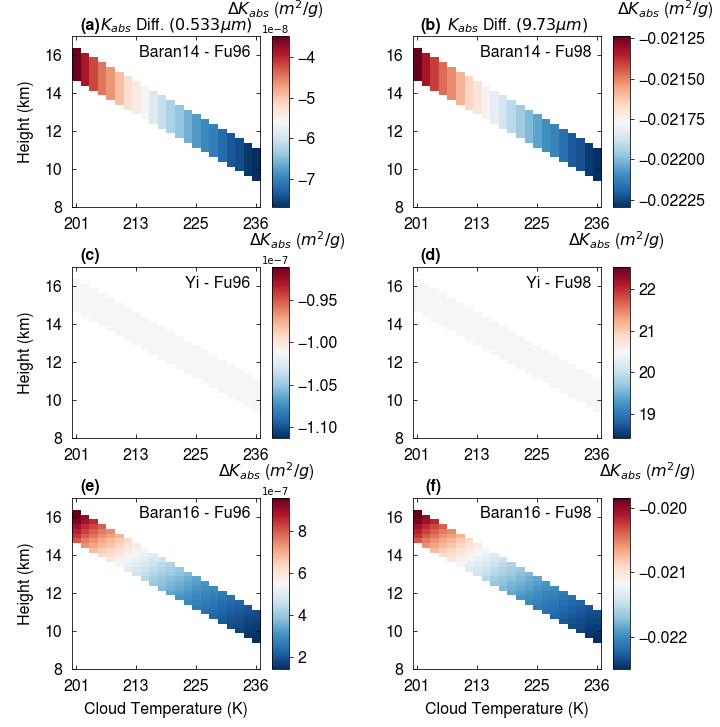

In [14]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 10 # inches

rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -1.5e-5
        vmaxi_sw   = 1e-10
        tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'RdBu_r'#'Reds'
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.035
        vmaxi_lw   = 1e-5
        tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'RdBu_r'#'Blues'
    elif diff == 1:
        # For SW:
        vmini_sw   = -8.4e-7
        vmaxi_sw   = 1e-14
        tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'RdBu_r'#'Reds'
        #For LW:
        vmini_lw   = -7e-3
        vmaxi_lw   = 1e-6
        tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'RdBu_r'#'Reds'
    elif diff == 2:
        # For SW:
        vmini_sw   = -1e-4
        vmaxi_sw   = 1e-9
        tickbar_sw = [vmini_sw, -.5e-4 , 0]
        #labelpad = -30
        cmap_sw    = 'RdBu_r'#'Reds'
        #For LW:
        vmini_lw   = 0.0413
        vmaxi_lw   = 0.04
        tickbar_lw = [vmini_lw, vmaxi_lw]
        cmap_lw    = 'RdBu_r'#'Blues'
    
    # Shortwave K_abs Difference
    im = ax[diff, 0].imshow(K_abs_sw_t1_diff_plot[diff], cmap = cmap_sw, aspect = 'auto')#,
                            #norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{abs}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'$K_{abs}$ Diff. $(0.533 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(K_abs_lw_t1_diff_plot[diff], cmap = cmap_lw, aspect = 'auto')#, 
                            #norm = MidpointNormalize(midpoint = 0.04065, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{abs}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'$K_{abs}$ Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_abs_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Yi - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Yi - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

## Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$:

Position of 30 um (Fixed Size):

In [7]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [8]:
fu_sw_K_ext = fu_sw.K_ext.values
fu_lw_K_ext = fu_lw.K_ext.values
baran14_sw_K_ext = baran14_sw.K_ext.values
baran14_lw_K_ext = baran14_lw.K_ext.values
yi_sw_K_ext = yi_sw.K_ext.values
yi_lw_K_ext = yi_lw.K_ext.values
baran16_sw_K_ext = baran16_sw.K_ext.values
baran16_lw_K_ext = baran16_lw.K_ext.values

Fu SW has some negative values for K_abs. Maybe because of high ssa. Check the parameterization.

In [9]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## K_ext Calculation Matrices:
K_ext_sw_t1 = np.zeros((4, tempi, profi))
K_ext_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
K_ext_sw_t1_plot = np.zeros((4, profi, tempi))
K_ext_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                K_ext_sw_t1[opt, i, q_ix] = 0
                K_ext_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                K_ext_sw_t1[0, i, q_ix] = fu_sw_K_ext[9, pos30, min_i] # Only One Band Selected 0.5 um
                K_ext_lw_t1[0, i, q_ix] = fu_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                K_ext_sw_t1[1, i, q_ix] = baran14_sw_K_ext[9, min_i] # Only One Band Selected 0.5 um 
                K_ext_lw_t1[1, i, q_ix] = baran14_lw_K_ext[6, min_i] # Only One Band Selected 9.7 um
                K_ext_sw_t1[2, i, q_ix] = yi_sw_K_ext[9, pos30, min_i] # Only One Band Selected 0.5 um
                K_ext_lw_t1[2, i, q_ix] = yi_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                K_ext_sw_t1[3, i, q_ix] = baran16_sw_K_ext[9, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                K_ext_lw_t1[3, i, q_ix] = baran16_lw_K_ext[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    K_ext_sw_t1_plot[opt,:,:] = np.transpose(K_ext_sw_t1[opt,:,:])
    K_ext_lw_t1_plot[opt,:,:] = np.transpose(K_ext_lw_t1[opt,:,:])

Interscheme Difference:

In [10]:
# Shortwave:
K_ext_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_sw_t1_diff_plot[0] = K_ext_sw_t1_plot[1] - K_ext_sw_t1_plot[0] # Baran2014 - Fu
K_ext_sw_t1_diff_plot[1] = K_ext_sw_t1_plot[2] - K_ext_sw_t1_plot[0] # Yi - Fu
K_ext_sw_t1_diff_plot[2] = K_ext_sw_t1_plot[3] - K_ext_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
K_ext_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_lw_t1_diff_plot[0] = K_ext_lw_t1_plot[1] - K_ext_lw_t1_plot[0] # Baran2014 - Fu
K_ext_lw_t1_diff_plot[1] = K_ext_lw_t1_plot[2] - K_ext_lw_t1_plot[0] # Yi - Fu
K_ext_lw_t1_diff_plot[2] = K_ext_lw_t1_plot[3] - K_ext_lw_t1_plot[0] # Baran2016 - Fu

In [11]:
# Shortwave K_abs differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(K_abs_sw_t1_diff_plot[0][np.nonzero(K_abs_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',K_abs_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_abs_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_abs_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',K_abs_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',K_abs_sw_t1_diff_plot[2].min())


print('')
# Longwave K_abs differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',K_abs_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',K_abs_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_abs_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_abs_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(K_abs_lw_t1_diff_plot[2][np.nonzero(K_abs_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(K_abs_lw_t1_diff_plot[2][np.nonzero(K_abs_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -3.505403031296542e-08
Baran2014 - Fu min:  -7.683225905817078e-08
Yi - Fu max:  0.0
Yi - Fu min:  -1.0121711925689131e-07
Baran2016 - Fu max:  9.564434500130715e-07
Baran2016 - Fu min:  0.0

Longwave CRH Differences:
Baran2014 - Fu max:  0.0
Baran2014 - Fu min:  -0.022296701234953073
Yi - Fu max:  20.476694320059792
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.019846396784980548
Baran2016 - Fu min:  -0.022500358286083575


In [11]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(K_ext_sw_t1_diff_plot[0][np.nonzero(K_ext_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',K_ext_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_ext_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_ext_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',K_ext_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',K_ext_sw_t1_diff_plot[2].min())


print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',K_ext_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',K_ext_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',K_ext_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',K_ext_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(K_ext_lw_t1_diff_plot[2][np.nonzero(K_ext_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(K_ext_lw_t1_diff_plot[2][np.nonzero(K_ext_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -0.04968871216745698
Baran2014 - Fu min:  -0.0520073169918618
Yi - Fu max:  0.0
Yi - Fu min:  -0.00407834161607238
Baran2016 - Fu max:  0.0
Baran2016 - Fu min:  -0.05203593705665501

Longwave CRH Differences:
Baran2014 - Fu max:  0.0
Baran2014 - Fu min:  -0.05682313200125607
Yi - Fu max:  0.0
Yi - Fu min:  -0.008007089388332785
Baran2016 - Fu max:  -0.04950840737953562
Baran2016 - Fu min:  -0.057027754739052625


In [12]:
K_ext_sw_t1_diff_plot[K_ext_sw_t1_diff_plot == 0] = np.nan
K_ext_lw_t1_diff_plot[K_ext_lw_t1_diff_plot == 0] = np.nan

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


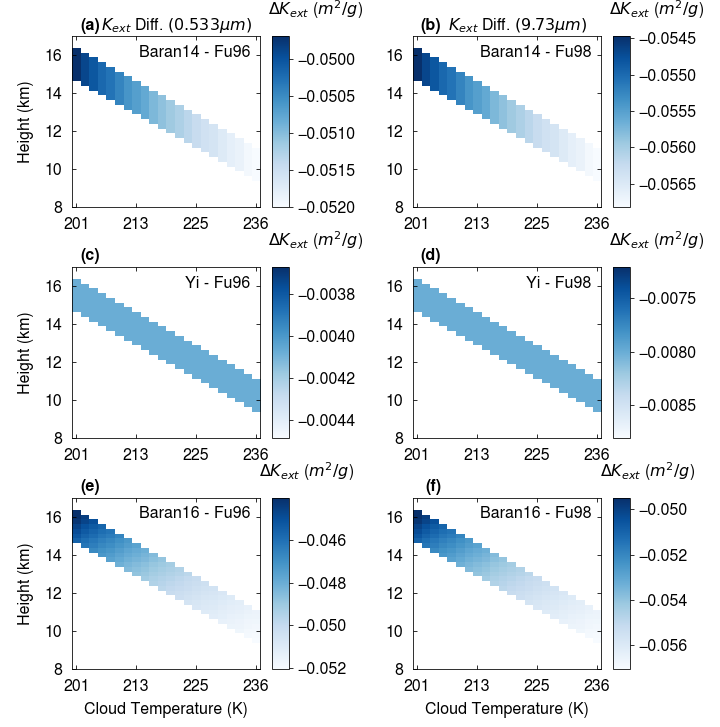

In [15]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 10 # inches

rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -1.5e-5
        vmaxi_sw   = 1e-10
        tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'Blues'#'Reds'
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.035
        vmaxi_lw   = 1e-5
        tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'Blues'#'Blues'
    elif diff == 1:
        # For SW:
        vmini_sw   = -8.4e-7
        vmaxi_sw   = 1e-14
        tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'Blues'#'Reds'
        #For LW:
        vmini_lw   = -7e-3
        vmaxi_lw   = 1e-6
        tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'Blues'#'Reds'
    elif diff == 2:
        # For SW:
        vmini_sw   = -1e-4
        vmaxi_sw   = 1e-9
        tickbar_sw = [vmini_sw, -.5e-4 , 0]
        #labelpad = -30
        cmap_sw    = 'Blues'#'Reds'
        #For LW:
        vmini_lw   = 0.0413
        vmaxi_lw   = 0.04
        tickbar_lw = [vmini_lw, vmaxi_lw]
        cmap_lw    = 'Blues'#'Blues'
    
    # Shortwave K_ext Difference
    im = ax[diff, 0].imshow(K_ext_sw_t1_diff_plot[diff], cmap = cmap_sw, aspect = 'auto')#,
                            #norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'$K_{ext}$ Diff. $(0.533 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(K_ext_lw_t1_diff_plot[diff], cmap = cmap_lw, aspect = 'auto')#, 
                            #norm = MidpointNormalize(midpoint = 0.04065, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta K_{ext}$ ($m^{2}/g$)', labelpad = -40, y = 1.22, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'$K_{ext}$ Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Yi - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Yi - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

### Single Scatter Albedo

Position of 30 um (Fixed Size):

In [16]:
pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [17]:
fu_sw_ssa = fu_sw.ssa.values
fu_lw_ssa = fu_lw.ssa.values
baran14_sw_ssa = baran14_sw.ssa.values
baran14_lw_ssa = baran14_lw.ssa.values
yi_sw_ssa = yi_sw.ssa.values
yi_lw_ssa = yi_lw.ssa.values
baran16_sw_ssa = baran16_sw.ssa.values
baran16_lw_ssa = baran16_lw.ssa.values

In [18]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## SSA Calculation Matrices:
ssa_sw_t1 = np.zeros((4, tempi, profi))
ssa_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
ssa_sw_t1_plot = np.zeros((4, profi, tempi))
ssa_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                ssa_sw_t1[opt, i, q_ix] = 0
                ssa_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                ssa_sw_t1[0, i, q_ix] = fu_sw_ssa[9, pos30, min_i] # Only One Band Selected 0.5 um
                ssa_lw_t1[0, i, q_ix] = fu_lw_ssa[6, pos30, min_i] # Only One Band Selected 9.7 um
                ssa_sw_t1[1, i, q_ix] = baran14_sw_ssa[9, min_i] # Only One Band Selected 0.5 um 
                ssa_lw_t1[1, i, q_ix] = baran14_lw_ssa[6, min_i] # Only One Band Selected 9.7 um
                ssa_sw_t1[2, i, q_ix] = yi_sw_ssa[9, pos30, min_i] # Only One Band Selected 0.5 um
                ssa_lw_t1[2, i, q_ix] = yi_lw_ssa[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                ssa_sw_t1[3, i, q_ix] = baran16_sw_ssa[9, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                ssa_lw_t1[3, i, q_ix] = baran16_lw_ssa[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    ssa_sw_t1_plot[opt,:,:] = np.transpose(ssa_sw_t1[opt,:,:])
    ssa_lw_t1_plot[opt,:,:] = np.transpose(ssa_lw_t1[opt,:,:])

Interscheme Difference:

In [19]:
# Shortwave:
ssa_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
ssa_sw_t1_diff_plot[0] = ssa_sw_t1_plot[1] - ssa_sw_t1_plot[0] # Baran2014 - Fu
ssa_sw_t1_diff_plot[1] = ssa_sw_t1_plot[2] - ssa_sw_t1_plot[0] # Yi - Fu
ssa_sw_t1_diff_plot[2] = ssa_sw_t1_plot[3] - ssa_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
ssa_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
ssa_lw_t1_diff_plot[0] = ssa_lw_t1_plot[1] - ssa_lw_t1_plot[0] # Baran2014 - Fu
ssa_lw_t1_diff_plot[1] = ssa_lw_t1_plot[2] - ssa_lw_t1_plot[0] # Yi - Fu
ssa_lw_t1_diff_plot[2] = ssa_lw_t1_plot[3] - ssa_lw_t1_plot[0] # Baran2016 - Fu

New version

In [21]:
# Shortwave SSA differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(ssa_sw_t1_diff_plot[0][np.nonzero(ssa_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',ssa_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',ssa_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',ssa_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',ssa_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',ssa_sw_t1_diff_plot[2].min())


print('')
# Longwave SSA differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',ssa_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',ssa_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',ssa_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',ssa_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(ssa_lw_t1_diff_plot[2][np.nonzero(ssa_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(ssa_lw_t1_diff_plot[2][np.nonzero(ssa_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  -8.010380148526508e-06
Baran2014 - Fu min:  -1.195588451852192e-05
Yi - Fu max:  1.8579331422241552e-06
Yi - Fu min:  0.0
Baran2016 - Fu max:  0.0
Baran2016 - Fu min:  -9.940202078773108e-05

Longwave CRH Differences:
Baran2014 - Fu max:  0.0
Baran2014 - Fu min:  -0.03429181045549656
Yi - Fu max:  0.0
Yi - Fu min:  -0.006607004646692394
Baran2016 - Fu max:  0.041296122856933626
Baran2016 - Fu min:  0.0401342788188942


In [22]:
ssa_sw_t1_diff_plot[ssa_sw_t1_diff_plot == 0] = np.nan
ssa_lw_t1_diff_plot[ssa_lw_t1_diff_plot == 0] = np.nan

In [23]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


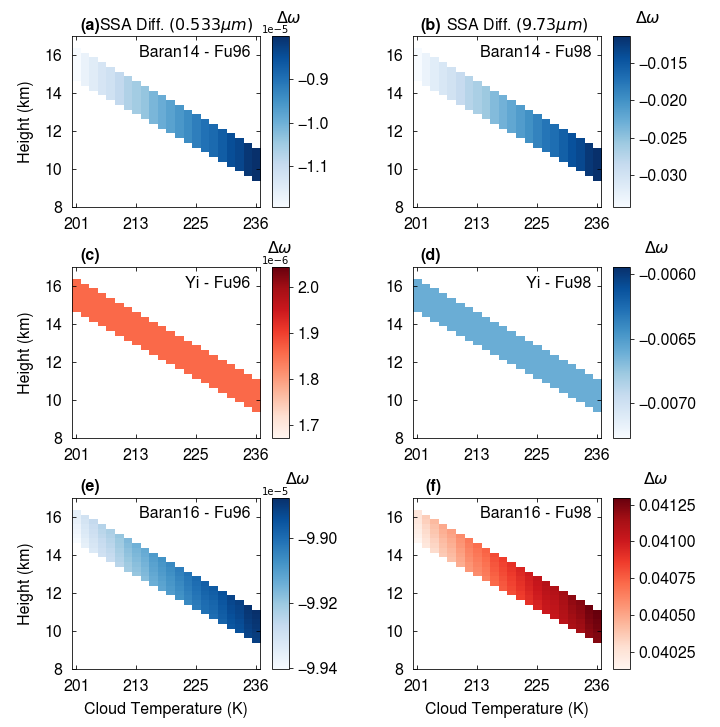

In [25]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 10 # inches

rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -1.5e-5
        vmaxi_sw   = 1e-10
        tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'Blues'
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.035
        vmaxi_lw   = 1e-5
        tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'Blues'
    elif diff == 1:
        # For SW:
        vmini_sw   = -8.4e-7
        vmaxi_sw   = 1e-14
        tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'Reds'
        #For LW:
        vmini_lw   = -7e-3
        vmaxi_lw   = 1e-6
        tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'Blues'
    elif diff == 2:
        # For SW:
        vmini_sw   = -1e-4
        vmaxi_sw   = 1e-9
        tickbar_sw = [vmini_sw, -.5e-4 , 0]
        #labelpad = -30
        cmap_sw    = 'Blues'
        #For LW:
        vmini_lw   = 0.0413
        vmaxi_lw   = 0.04
        tickbar_lw = [vmini_lw, vmaxi_lw]
        cmap_lw    = 'Reds'
    
    # Shortwave SSA Difference
    im = ax[diff, 0].imshow(ssa_sw_t1_diff_plot[diff], cmap = cmap_sw, aspect = 'auto')#,
                            #norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta \omega$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'SSA Diff. $(0.533 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(ssa_lw_t1_diff_plot[diff], cmap = cmap_lw, aspect = 'auto')#, 
                            #norm = MidpointNormalize(midpoint = 0.04065, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta \omega$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'SSA Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, ssa_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Yi - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Yi - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

## Asymmetry Parameter g:

Position of 30 um (Fixed Size):

In [26]:
# Ice Mass Mixing ratio (kg/kg):
q_i = np.arange(0.04, 0.11, 0.001) * 0.001
# Ice Water Content (g m-3), with average density of 0.3 kg m-3 between 10 km and 15 km:
iwc = q_i * 1000 * 0.3
# Effective Radius (um)
r_e = np.arange(5, 60, 1) # See limits of LUT from Yi in radiation_ice_optics_yi.F90 (< 60 um)
# Temperature
T = np.arange(190, 260.5, .5) # Temperature (K)

pos30 = np.where(r_e == 30)[0][0]

Test with only one band:
- SW: 0.625 um (wn1) - 0.441 um (wn2)
- LW: 10.2 um (wn1) - 9.259 um (wn2)

In [27]:
fu_sw_g = fu_sw.g.values
fu_lw_g = fu_lw.g.values
baran14_sw_g = baran14_sw.g.values
baran14_lw_g = baran14_lw.g.values
yi_sw_g = yi_sw.g.values
yi_lw_g = yi_lw.g.values
baran16_sw_g = baran16_sw.g.values
baran16_lw_g = baran16_lw.g.values

In [28]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## g Calculation Matrices:
g_sw_t1 = np.zeros((4, tempi, profi))
g_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
g_sw_t1_plot = np.zeros((4, profi, tempi))
g_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(4): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i]       # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                g_sw_t1[opt, i, q_ix] = 0
                g_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                g_sw_t1[0, i, q_ix] = fu_sw_g[9, pos30, min_i] # Only One Band Selected 0.5 um
                g_lw_t1[0, i, q_ix] = fu_lw_g[6, pos30, min_i] # Only One Band Selected 9.7 um
                g_sw_t1[1, i, q_ix] = baran14_sw_g[9, min_i] # Only One Band Selected 0.5 um 
                g_lw_t1[1, i, q_ix] = baran14_lw_g[6, min_i] # Only One Band Selected 9.7 um
                g_sw_t1[2, i, q_ix] = yi_sw_g[9, pos30, min_i] # Only One Band Selected 0.5 um
                g_lw_t1[2, i, q_ix] = yi_lw_g[6, pos30, min_i] # Only One Band Selected 9.7 um
                T_difference = np.absolute(T - temperature_hl[0][q_ix])
                min_Tdiff    = T_difference.argmin()
                g_sw_t1[3, i, q_ix] = baran16_sw_g[9, min_Tdiff, min_i] # Only One Band Selected 0.5 um 
                g_lw_t1[3, i, q_ix] = baran16_lw_g[6, min_Tdiff, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    g_sw_t1_plot[opt,:,:] = np.transpose(g_sw_t1[opt,:,:])
    g_lw_t1_plot[opt,:,:] = np.transpose(g_lw_t1[opt,:,:])

Interscheme Difference:

In [29]:
# Shortwave:
g_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
g_sw_t1_diff_plot[0] = g_sw_t1_plot[1] - g_sw_t1_plot[0] # Baran2014 - Fu
g_sw_t1_diff_plot[1] = g_sw_t1_plot[2] - g_sw_t1_plot[0] # Yi - Fu
g_sw_t1_diff_plot[2] = g_sw_t1_plot[3] - g_sw_t1_plot[0] # Baran2016 - Fu

# Longwave:
g_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
g_lw_t1_diff_plot[0] = g_lw_t1_plot[1] - g_lw_t1_plot[0] # Baran2014 - Fu
g_lw_t1_diff_plot[1] = g_lw_t1_plot[2] - g_lw_t1_plot[0] # Yi - Fu
g_lw_t1_diff_plot[2] = g_lw_t1_plot[3] - g_lw_t1_plot[0] # Baran2016 - Fu

Old version:

In [30]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(g_sw_t1_diff_plot[0][np.nonzero(g_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',g_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',g_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',g_sw_t1_diff_plot[2].min())


print('')
# Longwave g differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',g_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',g_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  4.6437372164365165e-05
Baran2014 - Fu min:  -0.0008167989975613743
Yi - Fu max:  0.00693823489290224
Yi - Fu min:  0.0
Baran2016 - Fu max:  0.0
Baran2016 - Fu min:  -0.004773708300233492

Longwave CRH Differences:
Baran2014 - Fu max:  0.016319549751121265
Baran2014 - Fu min:  0.0
Yi - Fu max:  0.009977025477858614
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.005000461667729161
Baran2016 - Fu min:  -0.005936482462657211


New version

In [30]:
# Shortwave g differences:
print('Shortwave CRH Differences:')
print('Baran2014 - Fu max: ',np.max(g_sw_t1_diff_plot[0][np.nonzero(g_sw_t1_diff_plot[0])]))
print('Baran2014 - Fu min: ',g_sw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_sw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_sw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',g_sw_t1_diff_plot[2].max())
print('Baran2016 - Fu min: ',g_sw_t1_diff_plot[2].min())


print('')
# Longwave g differences:
print('Longwave CRH Differences:')
print('Baran2014 - Fu max: ',g_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',g_lw_t1_diff_plot[0].min())
print('Yi - Fu max: ',g_lw_t1_diff_plot[1].max())
print('Yi - Fu min: ',g_lw_t1_diff_plot[1].min())
print('Baran2016 - Fu max: ',np.max(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))
print('Baran2016 - Fu min: ',np.min(g_lw_t1_diff_plot[2][np.nonzero(g_lw_t1_diff_plot[2])]))

Shortwave CRH Differences:
Baran2014 - Fu max:  4.6437372164365165e-05
Baran2014 - Fu min:  -0.0008167989975613743
Yi - Fu max:  0.00693823489290224
Yi - Fu min:  0.0
Baran2016 - Fu max:  0.0
Baran2016 - Fu min:  -0.004773708300233492

Longwave CRH Differences:
Baran2014 - Fu max:  0.016319549751121265
Baran2014 - Fu min:  0.0
Yi - Fu max:  0.009977025477858614
Yi - Fu min:  0.0
Baran2016 - Fu max:  -0.005000461667729161
Baran2016 - Fu min:  -0.005936482462657211


In [31]:
g_sw_t1_diff_plot[g_sw_t1_diff_plot == 0] = np.nan
g_lw_t1_diff_plot[g_lw_t1_diff_plot == 0] = np.nan

In [32]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


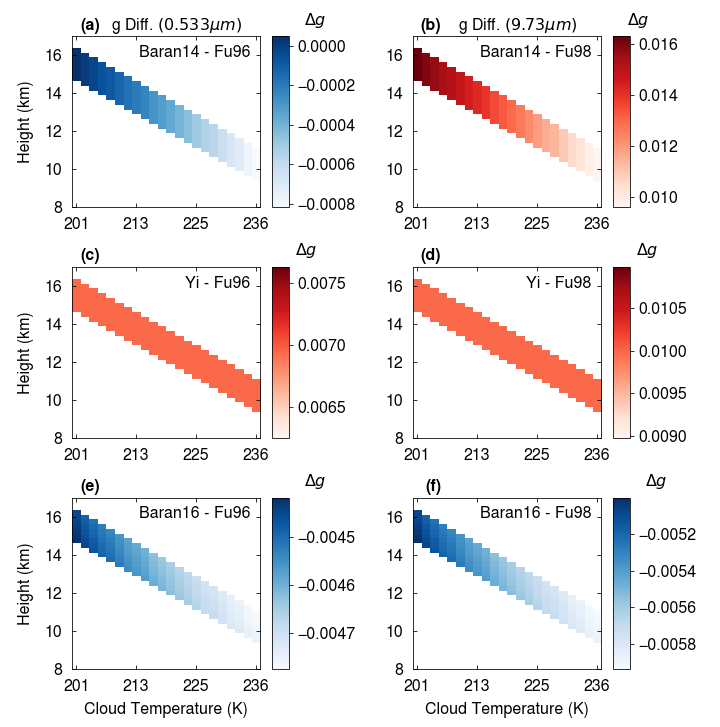

In [33]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 10.1 # inches
flength  = 10 # inches

rows    = 3
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.95, bottom = 0.08, left = 0.1, right = 0.9, 
                    hspace = .35, wspace = .45)

# COLORMAPS
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    if diff == 0:
        # For SW:
        vmini_sw   = -1.5e-5
        vmaxi_sw   = 1e-10
        tickbar_sw = [vmini_sw, -0.75e-5 , 0]
        cmap_sw    = 'Blues'#'RdBu_r'
        #labelpad    = -30
        #For LW:
        vmini_lw   = -0.035
        vmaxi_lw   = 1e-5
        tickbar_lw = [vmini_lw, -0.0175 , 0]
        cmap_lw    = 'Reds'#'RdBu_r'
    elif diff == 1:
        # For SW:
        vmini_sw   = -8.4e-7
        vmaxi_sw   = 1e-14
        tickbar_sw = [vmini_sw, -4.2e-7, 0]
        #labelpad = -30
        cmap_sw    = 'Reds'#'RdBu_r'
        #For LW:
        vmini_lw   = -7e-3
        vmaxi_lw   = 1e-6
        tickbar_lw = [vmini_lw, -3.5e-3 , 0]
        cmap_lw    = 'Reds'#'RdBu_r'
    elif diff == 2:
        # For SW:
        vmini_sw   = -1e-4
        vmaxi_sw   = 1e-9
        tickbar_sw = [vmini_sw, -.5e-4 , 0]
        #labelpad = -30
        cmap_sw    = 'Blues'#'RdBu_r'
        #For LW:
        vmini_lw   = 0.0413
        vmaxi_lw   = 0.04
        tickbar_lw = [vmini_lw, vmaxi_lw]
        cmap_lw    = 'Blues'#'RdBu_r'
    
    # Shortwave g Difference
    im = ax[diff, 0].imshow(g_sw_t1_diff_plot[diff], cmap = cmap_sw, aspect = 'auto')#,
                            #norm = MidpointNormalize(midpoint = 0, vmin = vmini_sw, vmax = vmaxi_sw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_sw)
    cbar.set_label(r'$\Delta g$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 0].set_title(r'g Diff. $(0.533 \mu m)$', color = 'black', x = 0.555, y = 1,
                              fontsize = fontsize, fontname = fontname)

    # Longwave Heating Rate
    im = ax[diff, 1].imshow(g_lw_t1_diff_plot[diff], cmap = cmap_lw, aspect = 'auto')#, 
                            #norm = MidpointNormalize(midpoint = 0.04065, vmin = vmini_lw, vmax = vmaxi_lw))
    cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar_lw)
    cbar.set_label(r'$\Delta g$', labelpad = -40, y = 1.15, rotation=0, 
                   fontsize = fontsize, fontname = fontname)
    cbar.ax.tick_params(labelsize = fontsize, pad = 5)
    for tick in cbar.ax.get_yticklabels():
        tick.set_fontname(fontname)
    if diff == 0:
        ax[diff, 1].set_title(r'g Diff. $(9.73 \mu m)$', color = 'black', x=0.555, y=1,
                              fontsize = fontsize, fontname = fontname)
        
# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, g_sw_t1.shape[2]+1, 8) # altitude tick labels
# height tickLabels are rounded for visualization:
yticklabels = (height_hl_pd.loc[yticks].round(1)-.1).astype('int').to_list()
    
# X Axis:
xticks      = np.arange(0, 28, 7) # 21 elements max
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()

Diff_sw         = ['Baran14 - Fu96', 'Yi - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Yi - Fu98', 'Baran16 - Fu98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)']
panel_letters_i = 0
for diff in range(rows): # Baran2014 - Fu, Yi - Fu, Baran2016 - Fu
    for j in range(columns):
        if diff == 2:
            ax[diff, j].set_xlabel(r'Cloud Temperature (K)', 
                                   fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 7.5)
        ax[diff, j].tick_params(axis = 'x', which = 'major', color = 'black',
                                size = 4, direction = 'in', top = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_xticks(xticks)
        ax[diff, j].set_xticklabels(xticklabels) #[::-1]
        ax[diff, j].tick_params(axis = 'y', which = 'major', color = 'black',
                                size = 4, direction = 'in', right = True,
                                labelsize = fontsize, pad = 10)
        for tick in ax[diff, j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[diff, j].set_yticks(yticks)
        ax[diff, j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff, j].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                   color ='black', labelpad = 10)
            ax[diff, j].text(0.95, 0.95, Diff_sw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[diff, j].text(0.95, 0.95, Diff_lw[diff],
                             ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                             fontsize = fontsize, fontname = fontname, color = 'black')
        ax[diff, j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        # Panel letters:
        ax[diff, j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                         ha = 'right', va = 'top', transform = ax[diff, j].transAxes,
                         fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1


# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_diff_1S_v6c.png', dpi=500)

### Extinction Coefficient $\beta_{ext}$ $(m^{-1})$ Comparison:

Position of 30 um from Fu matrix (Fixed Size):

In [28]:
pos30 = np.where(r_e == 30)[0][0]

Integral for broadband Extinction Coefficients (skipped for now):

fu_sw_b_ext_bb_pos30 = []
yi_sw_b_ext_bb_pos30 = []
fu_lw_b_ext_bb_pos30 = []
yi_lw_b_ext_bb_pos30 = []
for q_ix in range(len(q_i)):
    fu_sw_b_ext_bb_pos30.append(np.trapz(fu_sw_b_ext[-2::-1, pos30, q_ix], fu_sw_center_wl[-2::-1] * 1e-6))
    yi_sw_b_ext_bb_pos30.append(np.trapz(yi_sw_b_ext[-2::-1, pos30, q_ix], yi_sw_center_wl[-2::-1] * 1e-6))
    fu_lw_b_ext_bb_pos30.append(np.trapz(fu_lw_b_ext[-2::-1, pos30, q_ix], fu_lw_center_wl[-2::-1] * 1e-6))
    yi_lw_b_ext_bb_pos30.append(np.trapz(yi_lw_b_ext[-2::-1, pos30, q_ix], yi_lw_center_wl[-2::-1] * 1e-6))

Test with only one band:

In [76]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

fu_sw_b_ext_bb_pos30_matrix = np.zeros((4, tempi, profi))

b_ext_sw = np.zeros((4, tempi, profi))
b_ext_lw = np.zeros((4, tempi, profi))

## Matrices for plotting:
b_ext_sw_plot = np.zeros((4, profi, tempi))
b_ext_lw_plot = np.zeros((4, profi, tempi))

for opt in range(2): # per optical scheme (1,5)
    #ecrad_out = eval('ecrad_out_'+str(opt)+'O1S')
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure [Pa]
        q_i_prof = height_in.q_ice.values[i]
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                b_ext_sw[opt, i, q_ix] = 0
                b_ext_lw[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                mini         = q_difference.argmin()
                b_ext_sw[0, i, q_ix] = fu_sw_b_ext[9, pos30, mini] # Only One Band Selected 0.5 um
                b_ext_lw[0, i, q_ix] = fu_lw_b_ext[6, pos30, mini] # Only One Band Selected 9.7 um
                b_ext_sw[1, i, q_ix] = yi_sw_b_ext[9, pos30, mini] # Only One Band Selected 0.5 um
                b_ext_lw[1, i, q_ix] = yi_lw_b_ext[6, pos30, mini] # Only One Band Selected 9.7 um
                
    # For plotting:
    b_ext_sw_plot[opt,:,:] = np.transpose(b_ext_sw[opt,:,:])
    b_ext_lw_plot[opt,:,:] = np.transpose(b_ext_lw[opt,:,:])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00155263 0.00155263 0.00155263
 0.00155263 0.00155263 0.00155263 0.00155263 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00148726 0.001

In [ ]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 5 # inches
flength  = 12.75 # inches

rows    = 1
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.88, bottom = 0.15, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
#vmini = 0
#vmaxi = 60
#tickbar = [vmini, 0 ,10, 20, 30, 40, 50, vmaxi]

#For shortwave:
#vmini_sw = 0
#vmaxi_sw = 0.0015
#tickbar_sw = [vmini_sw, 0.0005 , 0.001, vmaxi_sw]

# Shortwave Extinction Coefficient:
im = ax[0].imshow(b_ext_sw_plot[0], cmap = 'Blues', aspect = 'auto')#,
                       #norm = MidpointNormalize(midpoint = 0, vmin = 0, vmax = 0.0015)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = [0, 0.0005 , 0.001, 0.0015])
cbar.set_label(r'$\beta_{e}$ $(m^{-1})$', labelpad = -30, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
if opt == 0:
    ax[0].set_title(r'SW $\beta_{e}$', color = 'black',
                         fontsize = fontsize, fontname = fontname)

# Longwave Extinction Coefficient:
im = ax[1].imshow(b_ext_lw_plot[0], cmap = 'Blues', aspect = 'auto')#, 
                       #norm = MidpointNormalize(midpoint = 0, vmin = 0, vmax = 0.0015))
cbar = plt.colorbar(im, aspect = 10, pad = 0.05)#, ticks = tickbar)
cbar.set_label(r'$\beta_{e}$ $(m^{-1})$', labelpad = -40, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
if opt == 0:
    ax[1].set_title(r'LW $\beta_{e}$', color = 'black',
                         fontsize = fontsize, fontname = fontname)


# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, b_ext_sw.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()    
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
OptSch_sw       = ['Fu 1996', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch_lw       = ['Fu, Yang & Sun 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
OptSch          = ['Fu 1996, 1998', 'Yi et al. 2013', 'Baran et al. 2016', 'Baran et al. 2014']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)','(j)','(k)','(l)']
panel_letters_i = 0
for opt in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #if opt == 3:
        ax[j].set_xlabel(r'Cloud Temperature (K)', 
                              fontsize = fontsize, fontname = fontname,
                              color ='black', labelpad = 7.5)
        ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[j].set_xticks(xticks)
        ax[j].set_xticklabels(xticklabels) #[::-1]
        ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(yticklabels)
        if j == 0:
            ax[opt].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[opt].text(0.95, 0.95, OptSch_sw[opt],
                            ha = 'right', va = 'top', transform = ax[j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[j].text(0.95, 0.95, OptSch_lw[opt],
                            ha = 'right', va = 'top', transform = ax[j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[opt, j].text(0.95, 0.95, OptSch[opt, j],
                            ha = 'right', va = 'top', transform = ax[opt].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_1S_v6.png', dpi=500)

### Mass Extinction Coefficient $K_{ext}$ $(m^2/g)$ Comparison:

Position of 30 um from Fu matrix (Fixed Size):

In [31]:
pos30 = np.where(r_e == 30)[0][0]

Integral for broadband Extinction Coefficients (skipped for now):

fu_sw_b_ext_bb_pos30 = []
yi_sw_b_ext_bb_pos30 = []
fu_lw_b_ext_bb_pos30 = []
yi_lw_b_ext_bb_pos30 = []
for q_ix in range(len(q_i)):
    fu_sw_b_ext_bb_pos30.append(np.trapz(fu_sw_b_ext[-2::-1, pos30, q_ix], fu_sw_center_wl[-2::-1] * 1e-6))
    yi_sw_b_ext_bb_pos30.append(np.trapz(yi_sw_b_ext[-2::-1, pos30, q_ix], yi_sw_center_wl[-2::-1] * 1e-6))
    fu_lw_b_ext_bb_pos30.append(np.trapz(fu_lw_b_ext[-2::-1, pos30, q_ix], fu_lw_center_wl[-2::-1] * 1e-6))
    yi_lw_b_ext_bb_pos30.append(np.trapz(yi_lw_b_ext[-2::-1, pos30, q_ix], yi_lw_center_wl[-2::-1] * 1e-6))

Test with only one band:

In [81]:
tempi = height_in.sizes['column']     # Temperature Levels
profi = height_in.sizes['half_level'] # Vertical Profile

## Calculation Matrices (m2/g):
K_ext_sw_t1 = np.zeros((4, tempi, profi))
K_ext_lw_t1 = np.zeros((4, tempi, profi))

## Matrices for plotting:
K_ext_sw_t1_plot = np.zeros((4, profi, tempi))
K_ext_lw_t1_plot = np.zeros((4, profi, tempi))

for opt in range(3): # per optical scheme (1,5)
    for i in range(tempi):
        pres     = height_in.pressure_hl.values[i] # Pressure (Pa)
        q_i_prof = height_in.q_ice.values[i] # Ice Water Mixing Ratio (kg / kg)
        for q_ix in range(len(q_i_prof)):
            if q_i_prof[q_ix] == 0: 
                K_ext_sw_t1[opt, i, q_ix] = 0
                K_ext_lw_t1[opt, i, q_ix] = 0
            else: 
                q_difference = np.absolute(q_i - q_i_prof[q_ix])
                min_i        = q_difference.argmin()
                K_ext_sw_t1[0, i, q_ix] = fu_sw_K_ext[9, pos30, min_i] # Only One Band Selected 0.5 um
                K_ext_lw_t1[0, i, q_ix] = fu_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                K_ext_sw_t1[1, i, q_ix] = baran14_sw_K_ext[9, min_i]*1e3 # Only One Band Selected 0.5 um 
                K_ext_lw_t1[1, i, q_ix] = baran14_lw_K_ext[6, min_i]*1e3 # Only One Band Selected 9.7 um
                print(baran14_sw_K_ext[9, min_i]*1e3)
                #K_ext_sw_t1[2, i, q_ix] = yi_sw_K_ext[9, pos30, min_i] # Only One Band Selected 0.5 um
                #K_ext_lw_t1[2, i, q_ix] = yi_lw_K_ext[6, pos30, min_i] # Only One Band Selected 9.7 um
                
    # For plotting:
    K_ext_sw_t1_plot[opt,:,:] = np.transpose(K_ext_sw_t1[opt,:,:])
    K_ext_lw_t1_plot[opt,:,:] = np.transpose(K_ext_lw_t1[opt,:,:])

4.789630974494307
4.789630974494307
4.789630974494307
4.789630974494307
4.789630974494307
4.789630974494307
4.789630974494307
4.58801362254342
4.58801362254342
4.58801362254342
4.58801362254342
4.58801362254342
4.58801362254342
4.58801362254342
4.436800576365491
4.436800576365491
4.436800576365491
4.436800576365491
4.436800576365491
4.436800576365491
4.436800576365491
4.285587499362941
4.285587499362941
4.285587499362941
4.285587499362941
4.285587499362941
4.285587499362941
4.285587499362941
4.184778762604898
4.184778762604898
4.184778762604898
4.184778762604898
4.184778762604898
4.184778762604898
4.184778762604898
4.0335656265535
4.0335656265535
4.0335656265535
4.0335656265535
4.0335656265535
4.0335656265535
4.0335656265535
3.882352449598504
3.882352449598504
3.882352449598504
3.882352449598504
3.882352449598504
3.882352449598504
3.882352449598504
3.7815436398445863
3.7815436398445863
3.7815436398445863
3.7815436398445863
3.7815436398445863
3.7815436398445863
3.7815436398445863
3.6807

Interscheme Difference:

In [82]:
# Shortwave:
K_ext_sw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_sw_t1_diff_plot[0] = K_ext_sw_t1_plot[1] - K_ext_sw_t1_plot[0] # Baran2014 - Fu
#K_ext_sw_t1_diff_plot[0] = K_ext_sw_t1_plot[1] - K_ext_sw_t1_plot[0] # Yi - Fu
#K_ext_sw_t1_diff_plot[1] = K_ext_sw_t1_plot[2] - K_ext_sw_t1_plot[0] # Baran2016 - Fu


# Longwave:
K_ext_lw_t1_diff_plot    = np.zeros((3, profi, tempi))
K_ext_lw_t1_diff_plot[0] = K_ext_lw_t1_plot[1] - K_ext_lw_t1_plot[0] # Baran2014 - Fu
#K_ext_lw_t1_diff_plot[0] = K_ext_lw_t1_plot[1] - K_ext_lw_t1_plot[0] # Yi - Fu
#K_ext_lw_t1_diff_plot[1] = K_ext_lw_t1_plot[2] - K_ext_lw_t1_plot[0] # Baran2016 - Fu

In [83]:
# Shortwave K_ext differences:
print('Shortwave CRH Differences:')
#print('Yi - Fu max: ',H_sw_diff_plot[0].max())
#print('Yi - Fu min: ',H_sw_diff_plot[0].min())
#print('Baran2016 - Fu max: ',H_sw_diff_plot[1].max())
#print('Baran2016 - Fu min: ',H_sw_diff_plot[1].min())
print('Baran2014 - Fu max: ',K_ext_sw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',K_ext_sw_t1_diff_plot[0].min())

print('')
# Longwave K_ext differences:
print('Longwave CRH Differences:')
#print('Yi - Fu max: ',H_lw_diff_plot[0].max())
#print('Yi - Fu min: ',H_lw_diff_plot[0].min())
#print('Baran2016 - Fu max: ',H_lw_diff_plot[1].max())
#print('Baran2016 - Fu min: ',H_lw_diff_plot[1].min())
print('Baran2014 - Fu max: ',K_ext_lw_t1_diff_plot[0].max())
print('Baran2014 - Fu min: ',K_ext_lw_t1_diff_plot[0].min())

Shortwave CRH Differences:
Baran2014 - Fu max:  4.735152631352356
Baran2014 - Fu min:  0.0

Longwave CRH Differences:
Baran2014 - Fu max:  4.786264555169465
Baran2014 - Fu min:  0.0


In [84]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return np.ma.masked_array(np.interp(value, x, y))

<IPython.core.display.Javascript object>


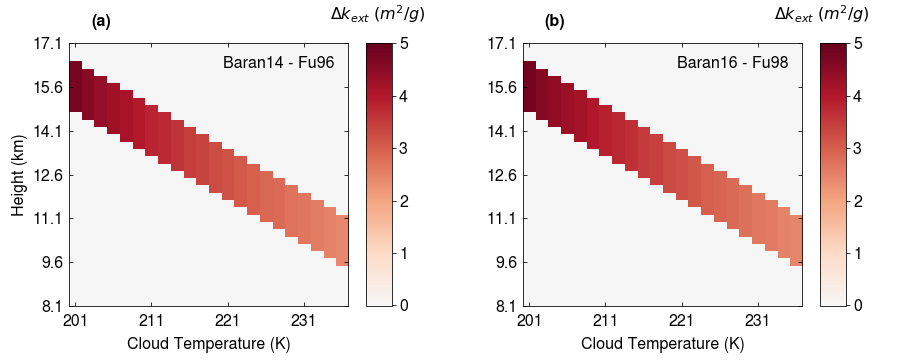

In [85]:
fontname = 'Nimbus Sans' # Arial
fontsize = 16
fheigth  = 5 # inches
flength  = 12.75 # inches

rows    = 1
columns = 2
f, ax   = plt.subplots(rows, columns, figsize = (flength, fheigth), dpi = 72)
plt.subplots_adjust(top = 0.88, bottom = 0.15, left = 0.075, right = 0.95, 
                    hspace = .3, wspace = .3)

# COLORMAPS
#vmini = 0
#vmaxi = 60
#tickbar = [vmini, 0 ,10, 20, 30, 40, 50, vmaxi]

#For shortwave:
#vmini_sw = 0
#vmaxi_sw = 0.0015
#tickbar_sw = [vmini_sw, 0.0005 , 0.001, vmaxi_sw]

# Shortwave Mass Extinction Coefficient Difference:
im = ax[0].imshow(K_ext_sw_t1_diff_plot[0], cmap = 'RdBu_r', aspect = 'auto',
                  norm = MidpointNormalize(midpoint = 0, vmin = -0.01, vmax = 5)) 
cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = [0, 1 , 2, 3, 4, 5])
cbar.set_label(r'$\Delta k_{ext}$ $(m^{2}/g)$', labelpad = -30, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
if opt == 0:
    ax[0].set_title(r'SW $k_{ext}$ Diff.', color = 'black',
                         fontsize = fontsize, fontname = fontname)

# Longwave Mass Extinction Coefficient Difference:
im = ax[1].imshow(K_ext_lw_t1_diff_plot[0], cmap = 'RdBu_r', aspect = 'auto', 
                  norm = MidpointNormalize(midpoint = 0, vmin = -0.01, vmax = 5))
cbar = plt.colorbar(im, aspect = 10, pad = 0.05, ticks = [0, 1 , 2, 3, 4, 5])
cbar.set_label(r'$\Delta k_{ext}$ $(m^{2}/g)$', labelpad = -40, y = 1.15, rotation=0, 
               fontsize = fontsize, fontname = fontname)
cbar.ax.tick_params(labelsize = fontsize)
for tick in cbar.ax.get_yticklabels():
    tick.set_fontname(fontname)
if opt == 0:
    ax[1].set_title(r'LW $k_{ext}$ Diff.', color = 'black',
                         fontsize = fontsize, fontname = fontname)


# AXIS PARAMETERS
# Y Axis
yticks      = np.arange(0, K_ext_sw_t1.shape[2]+1, 6) # altitude tick labels
yticklabels = height_hl_pd.loc[yticks].round(1).to_list()    
    
# X Axis:
xticks      = np.arange(0, 24, 6)
xticklabels = temp_range.iloc[xticks].round(0).astype('int').to_list()
    
Diff_sw         = ['Baran14 - Fu96', 'Yi13 - Fu96', 'Baran16 - Fu96']
Diff_lw         = ['Baran14 - Fu98', 'Yi13 - Fu98', 'Baran16 - Fu98']
Diff            = ['Baran14 - Fu96, 98', 'Yi13 - Fu96, 98', 'Baran16 - Fu96, 98']
panel_letters   = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)','(h)','(i)']
panel_letters_i = 0
for diff in range(rows): # Fu, Yi, Baran2016 and Baran 2014
    for j in range(columns):
        # Horizontal Lines:
        #h = ax[j,i].axhline(y = melting_layer_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #h = ax[j,i].axhline(y = tropopause_i, linestyle = 'dashed', color = 'grey',
        #                    dashes = (3, 2), linewidth  =2)
        #if opt == 3:
        ax[j].set_xlabel(r'Cloud Temperature (K)', 
                         fontsize = fontsize, fontname = fontname,
                         color ='black', labelpad = 7.5)
        ax[j].tick_params(axis = 'x', which = 'major', color = 'black',
                               size = 4, direction = 'in', top = True,
                               labelsize = fontsize, pad = 7.5)
        for tick in ax[j].get_xticklabels():
            tick.set_fontname(fontname)
        ax[j].set_xticks(xticks)
        ax[j].set_xticklabels(xticklabels) #[::-1]
        ax[j].tick_params(axis = 'y', which = 'major', color = 'black',
                               size = 4, direction = 'in', right = True,
                               labelsize = fontsize, pad = 5)
        for tick in ax[j].get_yticklabels():
            tick.set_fontname(fontname)
        ax[j].set_yticks(yticks)
        ax[j].set_yticklabels(yticklabels)
        if j == 0:
            ax[diff].set_ylabel('Height (km)', fontsize = fontsize, fontname = fontname,
                                  color ='black', labelpad = 5)
            ax[diff].text(0.95, 0.95, Diff_sw[diff],
                            ha = 'right', va = 'top', transform = ax[j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 1:
            ax[j].text(0.95, 0.95, Diff_lw[opt],
                            ha = 'right', va = 'top', transform = ax[j].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        if j == 2:
            ax[diff, j].text(0.95, 0.95, Diff[diff, j],
                            ha = 'right', va = 'top', transform = ax[opt].transAxes,
                            fontsize = fontsize, fontname = fontname, color = 'black')
        ax[j].set_ylim((height_hl_pd - 8).abs().argmin(), (height_hl_pd - 17).abs().argmin())
        
        # Panel letters:
        ax[j].text(0.15, 1.11, panel_letters[panel_letters_i], weight = 'bold',
                        ha = 'right', va = 'top', transform = ax[j].transAxes,
                        fontsize = fontsize, fontname = fontname, color = 'black')
        panel_letters_i += 1
        
# Save Figure:
out_dir = ('/home/u5/edgardo/p01_crh_sensitivity/out_figures/')
#plt.savefig(out_dir+'1D_matrix_height_1S_v6.png', dpi=500)